# Parameter estimation tutorial

There are a quite a few steps to analyse GW data. Today we'll focus on the middle panel:
![Screen-Shot-2022-11-21-at-10-35-12-pm-1.png](https://i.postimg.cc/dtLCYm7Y/Screen-Shot-2022-11-21-at-10-35-12-pm-1.png)

Note: this notebook has been created by adapting materials from:
1) [Colm Talbots' inference series](https://github.com/ColmTalbot/intoduction_to_inference)
2) [Bilby's fast GW injection example](https://git.ligo.org/lscsoft/bilby/-/blob/master/examples/gw_examples/injection_examples/fast_tutorial.py)
3) [Bilby's GW150914 example](https://git.ligo.org/lscsoft/bilby/-/blob/master/examples/gw_examples/data_examples/GW150914.py)

In [1]:
! pip install bilby[gw]==1.4.1 -q
# NOTE: you'll have to restart your runtime after this

In [2]:
%matplotlib inline
import bilby
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from corner.core import quantile
from corner import corner
import requests
from tqdm.auto import tqdm
import logging
import warnings
import os


np.random.seed(42)
INJECTION_URL = "https://sandbox.zenodo.org/record/1163982/files/injection_result.json?download=1"
GW150914_URL = "https://sandbox.zenodo.org/record/1164558/files/GW150914_result.json?download=1"
GW200308_URL = "https://zenodo.org/record/5546663/files/IGWN-GWTC3p0-v1-GW200308_173609_PEDataRelease_mixed_cosmo.h5?download=1"



def notebook_setup():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    logger = logging.getLogger("root")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("bilby")
    logger.setLevel(logging.INFO)
    plt.style.use("default")
    plt.rcParams["savefig.dpi"] = 100
    plt.rcParams["figure.dpi"] = 100
    plt.rcParams["font.size"] = 16
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
    plt.rcParams["font.cursive"] = ["Liberation Sans"]
    plt.rcParams["mathtext.fontset"] = "custom"
    plt.rcParams["axes.grid"] = False


def download(url: str, fname: str):
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    if os.path.exists(fname):
        return
    with open(fname, 'wb') as file, tqdm(
        desc=f"Downloading {fname}",
        total=total,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)
            


notebook_setup()

In [3]:
RE_RUN_SLOW_CELLS = False
OUTDIR = "outdir"

# Bayesian Inference intro


To start, lets take a look at Bayes' theorem:

\begin{align}
\rm{Posterior} &= \frac{\rm{Prior} * \rm{Likelihood}}{\rm{Evidence}}  \\
\implies P(\theta|\rm{data}) &= \frac{\pi(\theta)\  \mathcal{L}(\rm{data}|\theta)}{\int_{\theta} \pi(\theta)\ \mathcal{L}(\rm{data}|\theta)\ d\theta}\\
 &= \frac{\pi(\theta)\  \mathcal{L}(\rm{data}|\theta)}{\mathcal{Z}(data)}
\end{align}

For a primer on Bayesian inference in GW, please look at [Eric Thrane + Colm Talbot's paper](https://arxiv.org/abs/1809.02293).



In this workshop we will focus more on how we can perform inference and not focus too much on the maths. 

Lets look at an example of how we can use Bayesian inference to analyse the following data:

In [4]:
observation = np.array([
    -1.65, 1.93, 2.88, -2.28, -1.02, 0.35, 1.49, 0.65, -1.95, 
    3.64, -2.47, 3.91, -2.16, 1.03, 0.6, 6.96, 1.07, -2.69, 
    -7.18, -0.94, -1.37, -1.09, -2.07, 6.28, 1.73, 1.0, 4.11,
    1.29, -1.21, -1.06, 3.67, 0.91, 0.64, -0.4, 9.2, -3.51, 
    1.89, -2.49, 5.43, 2.36, 0.18, 0.01, 6.85, 2.25, 3.55, 
    3.43, 3.1, 3.98, -1.06, 6.79, 3.27, -1.62, -4.16, -0.19,
    1.75, 6.18, -0.72, -1.4, 0.55, 4.85, 6.83, 10.35, 3.83, 
    5.46, -0.81, 0.91, 3.36, 2.01, 4.37, 4.03, 6.05, 2.62, 
    5.16, 3.57, 3.74, 7.07, 3.89, 9.91, 3.89, 3.41, 7.71, 2.79,
    3.98, 4.91, 1.87, 2.65, 3.4, 3.42, 11.26, 5.06, 8.83, 2.87, 
    8.66, 3.95, 6.05, 8.2, 3.07, 2.88, 4.6, 3.84
])
time = np.array([
    0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1,
    1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 
    2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 
    3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 
    4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 
    6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 
    7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 
    8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 
    9.6, 9.7, 9.8, 9.9
])

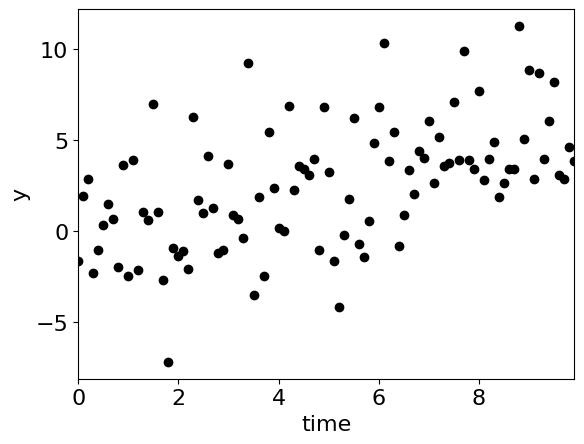

In [5]:
def plot_data(ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(time, observation, "o", color='k', zorder=-10)
    ax.set_xlabel("time")
    ax.set_ylabel("y");
    ax.set_xlim(min(time), max(time))

plot_data()

Lets assume:
1) The observed data `d(t)` consists of the following: `d(t) = n(t) + s(t)`.
2) The noise `n(t)` is `Gaussian white noise` (drawn from a Normal distribution).
3) The signal `s(t)` is a straight-line signal. 

With these assumptions, we can start implementing our Bayesian inference pipeline.

## Signal Model
Assuming a straight line signal:

In [6]:
def signal_model(time, m, c):
    return time * m + c

## Priors
Now we can write down some priors on the parameters `m` and `c` of this model. 
This is what we think our parameters can potentially be.  



In [7]:
import bilby

priors = bilby.core.prior.PriorDict(dict(
    m=bilby.core.prior.TruncatedNormal(mu=0, sigma=1, minimum=0, maximum=3, name="m"),
    c=bilby.core.prior.Uniform(-5, 5, name="c"),
))

To test our prior, lets draw some prior samples and print some samples:

In [8]:
import pandas as pd
pd.DataFrame(priors.sample(5))

,m,c
0,0.486700,-3.440055
1,1.944357,-4.419164
2,1.103103,3.661761
3,0.836350,1.011150
4,0.196265,2.080726


Lets plot some histograms of these samples in a `corner` plot:

Text(0.5, 0.98, 'Prior Samples')

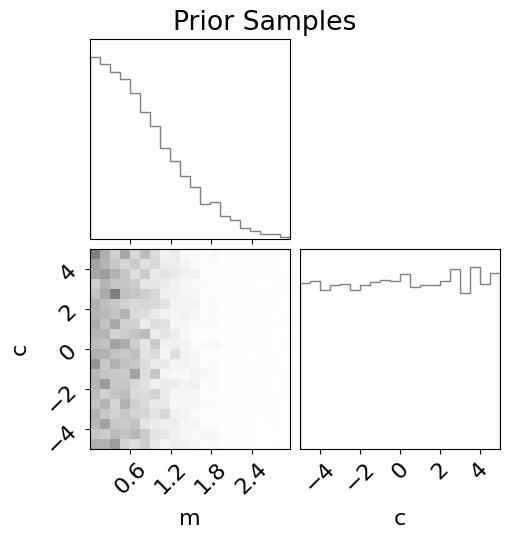

In [9]:
from corner import corner
fig = corner(
    pd.DataFrame(priors.sample(10000)),
    plot_datapoints=False, 
    plot_contours=False, plot_density=True,
    color="tab:gray",
    labels=list(priors.keys()),
)
fig.suptitle("Prior Samples");

Here each column/row represents one parameter. 

The plots along the upper diagonal show the 1D histograms of the parameters.
In the above, these represent `pi(m)` and `pi(c)` -- the prior distributions for `m` and `c`. 

The plots on the inside of the corner show the 2D histograms for the intersecting parameters.
Here, the 2D join distribution is `pi(m,c)`.


At this point, lets test out our model and priors:

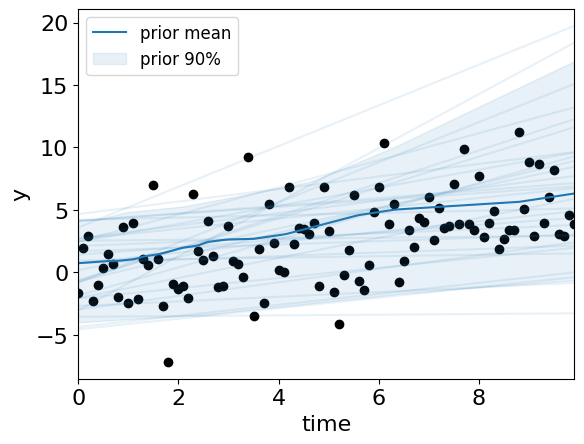

In [10]:
def plot_model_on_data(samples, plot_each_sample=False, color="tab:blue", ax=None, label="model"):
    m, c = samples['m'], samples['c']
    
    ys = np.array([signal_model(time, mi, ci) for mi, ci in zip(m, c)]).T
    
    if ax is None:
        fig, ax = plt.subplots()

    y_low, y_mean, y_up = np.quantile(ys, [0.05, 0.5, 0.95], axis=1)
    ax.plot(time, y_mean, color=color, label=f"{label} mean")
    ax.fill_between(time, y_low, y_up, alpha=0.1, color=color, label=f"{label} 90%")

    if plot_each_sample:
        for y in ys.T:
            ax.plot(time, y, color=color, alpha=0.1)
        
    plot_data(ax)
    ax.legend(frameon=True, fontsize=12)
    return ax.get_figure()


    
fig = plot_model_on_data(priors.sample(30), True, label="prior")


Looks like the model can potentially fit the data! Lets try to use the Bayesian inference framework to help us get estimates on the model parameters. 

## Likelihood

Recall the assumption that `d(t) = n(t) + s(t)`, and that the noise is normally distributed. Using this, we can write:

\begin{align}
n(t) &= s(t) - d(t)\\
&= \mathcal{N}(\sigma=3, \mu=0)
\end{align}

[NOTE: we've hardcoded `sigma` here, but you could add in a prior on `sigma` as well]

Hence, we can write out the signal-model likliood `L(data|m,c)` as:

\begin{align}
\mathcal{L}(\rm{data}|m,c) = \prod_j \rm{Normal}_{\rm{PDF}}(\left[d - s_j\right]; \mu=0,\sigma=3)
\end{align}

This type of `Gaussian` likelihoods has already been coded up in `bilby`:

In [11]:
likelihood = bilby.likelihood.GaussianLikelihood(time, observation, signal_model, sigma=3)

Let's test if we can compute a likelihood and dont get a nan:

In [12]:
# we need to provide the parameter to compute the likeliood for
likelihood.parameters = dict(m=0, c=0)
print(f"Log Likelihood (data| {likelihood.parameters}) = {likelihood.log_likelihood():.2f}")

Log Likelihood (data| {'m': 0, 'c': 0}) = -302.77


## Brute force posterior computation

We now have everything we need to compute our posterior! 
In the first pass, lets compute the posterior over a grid of `m` and `c` values:


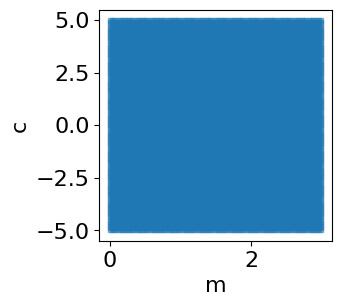

In [13]:
def get_grid_of_m_c(n_per_dim, prior):
    assert "m" in prior and "c" in prior
    samples = pd.DataFrame(prior.sample(10000))
    m_vals = np.linspace(min(samples.m), max(samples.m), n_per_dim)
    c_vals = np.linspace(min(samples.c), max(samples.c), n_per_dim)
    m_grid, c_grid = np.meshgrid(m_vals, c_vals)
    return pd.DataFrame(dict(m=m_grid.flatten(), c=c_grid.flatten()))


def plot_grid(m_c_grid, c="tab:blue", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3,3))
    ax.scatter(m_c_grid.m, m_c_grid.c, c=c, s=12.5, marker='s',alpha=0.5)
    ax.set_xlabel("m");
    ax.set_ylabel("c");
    return ax.figure
    

m_c_grid = get_grid_of_m_c(100, priors)
fig = plot_grid(m_c_grid)


Computing the prior, likelhood and posterior at each grid-point:

Brute force log evidence = -250.1758114091579



Brute force LnL computation: 100%|##########| 10000/10000 [00:00<00:00, 11415.85it/s]


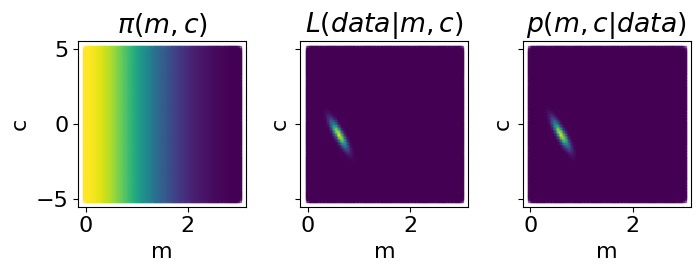

In [14]:

def run_brute_force_analysis(likelihood, prior, samples_list):
    n = len(samples_list)
    log_likelihoods = np.zeros(n)
    log_priors = np.zeros(n)
    log_posteriors = np.zeros(n) 
    log_evidence = 0 
    for i in tqdm(range(n), desc="Brute force LnL computation"):
        likelihood.parameters = samples_list[i]
        log_likelihoods[i]=likelihood.log_likelihood()
        log_priors[i] = prior.ln_prob(samples_list[i])
        log_posteriors[i] = log_priors[i] + log_likelihoods[i]
    log_evidence = np.logaddexp.reduce(log_posteriors+log_priors)
    
    return dict(
        samples=pd.DataFrame(samples_list),
        log_evidence=log_evidence,
        likelihood=np.exp(log_likelihoods),
        prior=np.exp(log_priors),
        posterior=np.exp(log_posteriors)
    )


def plot_grids_of_brute_result(res, xlims=None, log_vals=False):
    fig, axes = plt.subplots(1,3, sharey=True, figsize=(7.5,3))
    pi, post, like = res['prior'], res['posterior'], res['likelihood']
    prefix = ""
    if log_vals:
        pi, post, like = np.log(pi), np.log(post), np.log(like)
        prefix = "log "
    axes[0].set_title(prefix+"$\pi(m,c)$")
    plot_grid(m_c_grid, c=pi, ax=axes[0])
    axes[1].set_title(prefix+"$L(data|m,c)$")
    plot_grid(m_c_grid, c=like, ax=axes[1])
    axes[2].set_title(prefix+"$p(m,c|data)$")
    plot_grid(m_c_grid, c=post, ax=axes[2])
    if xlims is not None:
        for ax in axes:
            ax.set_xlim(*xlims)
    fig.tight_layout()
    return fig
    
brute_result = run_brute_force_analysis(likelihood, priors, m_c_grid.to_dict('records'))
fig = plot_grids_of_brute_result(brute_result)
print(f"Brute force log evidence = {brute_result['log_evidence']}")


Looks like the answer is around 
\begin{align}
0<m<1, 1 < c < -2
\end{align}

We can even compute the marginal posteriors:

\begin{align}
p(m|d)&= \int_c p(m,c|d)\ dc\\
p(c|d)&= \int_m p(m,c|d)\ dm
\end{align}
These will give us the estimated values for the model parameters

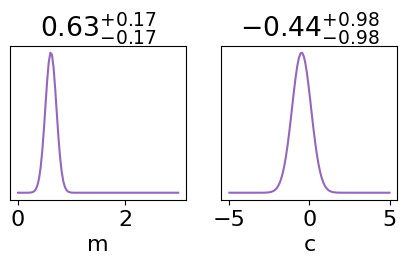

In [15]:
from corner.core import quantile

def get_marginalised_posterior(parameter, res):
    grid = res["samples"].copy()
    unique_values = np.unique(grid[parameter])
    log_post = np.zeros(len(unique_values))
    grid['log_post'] = np.log(res['posterior'])
    for i, value in enumerate(unique_values):
        subset = grid[grid[parameter] == value]
        log_post[i] = np.logaddexp.reduce(subset["log_post"])
    return unique_values, np.exp(log_post)


fig, axes = plt.subplots(1,2, figsize=(5,2))
for ax, p in zip(axes, ['m', 'c']):
    x, p_of_x = get_marginalised_posterior(p, brute_result)
    ax.plot(x, p_of_x, color="tab:purple")
    low, mean, up = quantile(x, q=[0.05, 0.5, 0.95], weights=p_of_x)
    low, up = mean-low, up-mean
    title = r"${{{0:.2f}}}_{{-{1:.2f}}}^{{+{2:.2f}}}$".format(mean, low, up)
    ax.set_yticks([])
    ax.set_title(title)
    ax.set_xlabel(p)

Lets also plot the posterior predictive check:

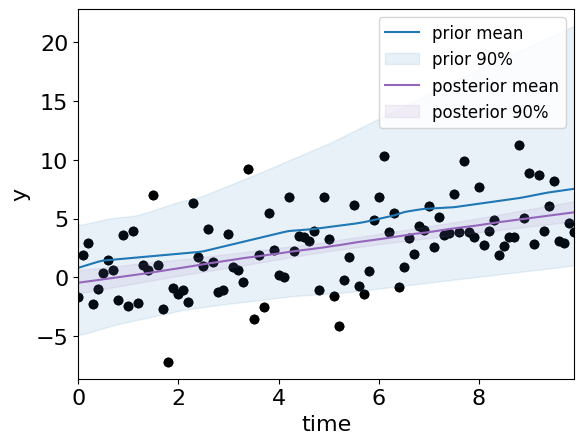

In [16]:
fig = plot_model_on_data(priors.sample(30), label="prior")
fig = plot_model_on_data(
    m_c_grid.sample(30, weights=brute_result['posterior']),
    color="tab:purple", ax=fig.axes[0], label="posterior"
)


This time with just the posterior:

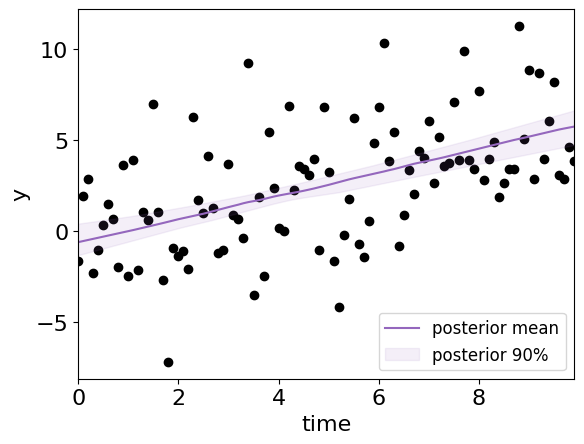

In [17]:
fig = plot_model_on_data(
    m_c_grid.sample(30, weights=brute_result['posterior']),
    color="tab:purple", label="posterior"
)

## Sampling from the posterior

There are some drawbacks from brute-force posterior estimation. 

What happens when the number of parameters increases to 15?

Drawing samples from the posterior and trying to estimate the likelihood may be a cheaper approach.

Below is some code to demonstrate how we can use bilby + a `nested` sampler "dynesty" to do this:

In [18]:
def sampler_run():
    result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        nlive=500,
        sample="unif",
        outdir=OUTDIR,
        label="linear_regression",
    )
    return result

sampler_result = sampler_run()

Now we can make some plots. 

First, lets plot the `corner` plot, and overplot the prior (in green) in the 1D distribution: 

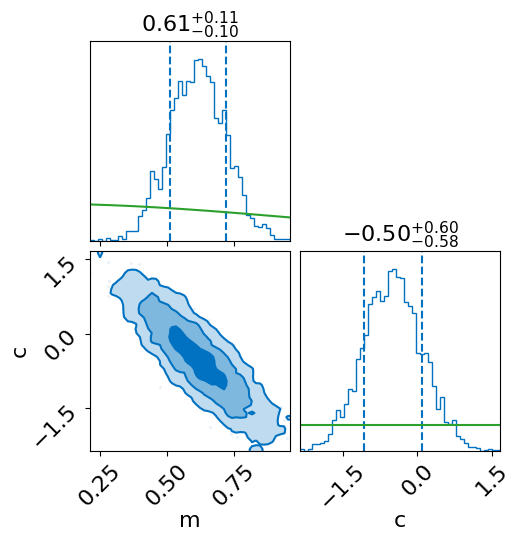

In [19]:
fig = sampler_result.plot_corner(priors=True, save=False)

Now lets check how well we have done (comparing against the true value):

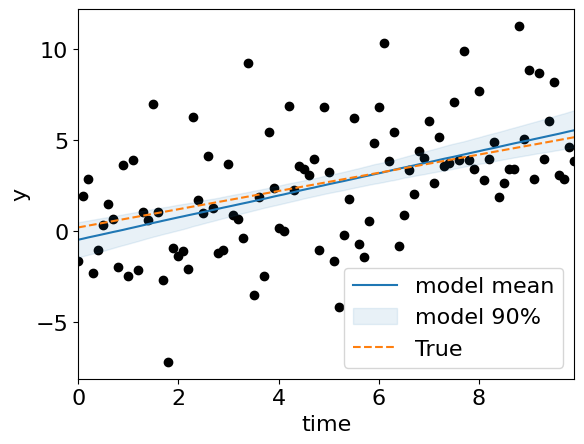

In [20]:
truths = {'c': 0.2, 'm': 0.5, 'sigma': 3}

fig = plot_model_on_data(sampler_result.posterior.sample(1000))
fig.axes[0].plot(time, signal_model(time, m=truths['m'], c=truths['c']), color="tab:orange", ls='--', label="True")
fig.axes[0].legend();


Lets finally compare the brute-force results and the nested-sampling results: 

Brute force ln_evidence: -250.1758114091579
Sampler ln_evidence: -253.34704697023392


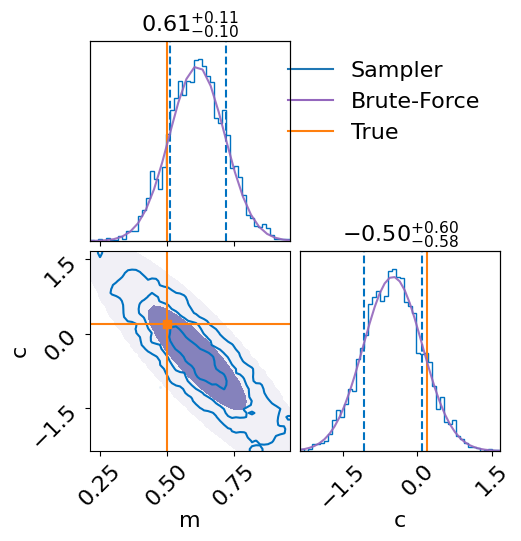

In [21]:
def overplot_sampler_and_brute_force(sampler_result, brute_result, truths):
    truths = dict(m=truths["m"], c=truths["c"])
    fig = sampler_result.plot_corner(parameters=truths, save=False)
    # overplot the grid estimates
    axes = fig.axes
    
    # add marginals 
    for p, axi in zip(["m", "c"],[0, 3]):
        ax = axes[axi].twinx()
        ax.set_yticks([])
        x, p_of_x = get_marginalised_posterior(p, brute_result)
        ax.plot(x, p_of_x, color="tab:purple", alpha=0.9)
        ax.set_ylim(0, 1.15 * np.max(p_of_x))
        
    
    samples_grid = brute_result['samples']
    n_cells = int(np.sqrt(len(samples_grid)))
    m_grid = samples_grid['m'].values.reshape(n_cells, n_cells)
    c_grid = samples_grid['c'].values.reshape(n_cells, n_cells)
    posterior_grid = brute_result['posterior'].reshape(n_cells, n_cells)
    axes[2].contourf(
        m_grid, c_grid, posterior_grid, 
        levels=np.quantile(posterior_grid, [0.95, 0.99, 1]),
        cmap="Purples"
    )
    axes[1].plot([],[], label="Sampler", color="tab:blue")
    axes[1].plot([],[], label="Brute-Force", color="tab:purple")
    axes[1].plot([],[], label="True", color="tab:orange")
    axes[1].legend(frameon=False, loc='upper right')
    print(f"Brute force ln_evidence: {brute_result['log_evidence']}")
    print(f"Sampler ln_evidence: {sampler_result.log_evidence}")


overplot_sampler_and_brute_force(sampler_result, brute_result, truths)

Both sets of results match up quite well! Even the log-evidences are comparable. 

Lets move on to GW signals! 

# CBC GW  Signal Model

The GW from compact binary coalescence (CBC) systems can be modeled using the following parameters:

- 2 mass parameters (eg m1, m2)
- 6 spin parameters (eg s1x, s1y, s1z, ...)
- 2 tidal deformation parameters (for neutron stars, lambda1, lambda2)
- 2 orbital eccentricity parameters (e, arg of periastron) 
- 7 extrinsic parameters (distance, sky-loc, timing, phase)


Some of these are shown here:

<div>
<img src="https://gcdnb.pbrd.co/images/EfwMgftuS4L5.png?o=1" width="350"/>
</div>



Additionally, there are quite a few re-parameterisations of these. 

For example, instead of the component masses $m_1, m_2$, one could also use the 
- `mass_ratio`: `q=m_2/m_1` where `m_1>m_2`, and 
- `chirp_mass`: 
\begin{align}
\mathcal{M} = \frac{(m_1 m_2)^{3/5}}{(m_1 + m_2)^{1/5}}
\end{align}

Similarly, we can use parameterize the dimensionless spins with the following 6 parameters:
- `chi_i` or $a_i$ : the spin magnitude (`0<a_i<1`) 
- `theta_i` or `tilt_i`: the angle of the component binary wrt the `z` axis (along the orbital axis)
- `phi_12`: the difference between the component spins projected on the `xy` plane (along the orbital plane)
-  `theta_jl`: the angle between the orbital angular momentum `L` vector and the total angular momentum vector `J`. 



Lets go over all the parameters in more detail:


````{tab} Intrinsic parameters

**INTRINSIC PARAMETERS**

* Mass: 2D
  - Usually uniform in two mass parameters
  - Component masses widely used (`m_1, m_2`)
  - "Chirp" mass and mass ratio a more convenient basis
  - Usually specified in the "detector-frame", redshifted relative to true "source-frame" mass
* Dimensionless Spin: 6D
  - Fully precessing (see animation)
    - usually uniform in magnitude and isotropic in orientation
  - Only spin aligned with orbital angular momentum - set planar spin components to zero
    - same prior on aligned spin as in the precessing case
    - uniform in aligned spin
  - Zero spin
    - all spin components are zero
    - smaller space to sample
* Orbital eccentricity: 1D/2D 
  - Often ignored (eccentricity and argument of periastron)
* Matter effects (for neutron stars): 2D
  - Two tidal deformability parameters `Lambda_i`
  - Parameters describing the neutron star equation of state (EoS)
    - Variable number
    - Zero-dimensional for fixed equation of state
    
````
````{tab} Extrinsic parameters 

**EXTRINSIC PARAMETERS**

* Location: 3D
  - ra, dec, distance
  - Usually isotropic over the sky
  - Distance prior uniform in volume
    - Should include cosmological effects
  - Use host galaxy location, e.g., GW170817, S190521g(?)
* Orientation: 4D
  - Three Euler angles (phase, inclination, polarisation)
    - Assumed to be distributed isotropically
* Merger time
    - Uniform based on expected uncertainty in trigger time
    - Typically ~ 0.1s
````

Note: increasing the spin in the x-y components can lead to precession.


<div>
<img src="https://media4.giphy.com/media/NF76iRgEerkx0qrsD0/giphy.gif?cid=790b76113d85f36207d50f4d1f42feead29a3c4cb8f2f1a6&rid=giphy.gif&ct=g" width="350"/>
</div>


Such a highly precessing system may be found in globular clusters/AGNs. 


Lets plot our own waveform:


In [22]:
import bilby
from bilby.gw.conversion import chirp_mass_and_mass_ratio_to_component_masses
import numpy as np
import logging

bilby_logger = logging.getLogger("bilby")
bilby_logger.setLevel(logging.ERROR)

def make_waveform_generator(approximant="IMRPhenomPv2", duration=4, sampling_frequency=1024,
                            frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole, ):
    """Create a waveform generator"""
    generator_args = dict(
        duration=duration,
        sampling_frequency=sampling_frequency,
        frequency_domain_source_model=frequency_domain_source_model,
        waveform_arguments=dict(
            waveform_approximant=approximant,
            reference_frequency=20.,
        )
    )
    return bilby.gw.WaveformGenerator(**generator_args)


def compute_waveform(waveform_generator, signal_parameters={}):
    """Compute the waveform"""
    parameters = dict(
        # two mass parameters
        mass_1=30, mass_2=30,
        # 6 spin parameters
        a_1=0.0, a_2=0.0, tilt_1=0, tilt_2=0, phi_jl=0, phi_12=0,
        # 2 tidal deformation parameters (for NS)
        lambda_1=0, lambda_2=0,
        # 7 extrinsic parameters (skyloc, timing, phase, etc)
        luminosity_distance=1000,
        theta_jn=0, ra=0, dec=0,
        psi=0, phase=0,
        geocent_time=0,
    )
    parameters.update(signal_parameters)
    bilby_logger.info(f"computing waveform with parameters: {parameters}")
    h = waveform_generator.time_domain_strain(parameters)
    t = waveform_generator.time_array
    approximant = waveform_generator.waveform_arguments["waveform_approximant"]
    delta_t = 1. / waveform_generator.sampling_frequency

    if "IMR" in approximant:
        # IMR templates the zero of time is at max amplitude (merger)
        # thus we roll the waveform back a bit
        for pol in h.keys():
            h[pol] = np.roll(h[pol], - len(h[pol]) // 3)

    h_phase = np.unwrap(np.arctan2(h['cross'], h['plus']))
    h_freq = np.diff(h_phase) / (2 * np.pi * delta_t)
    # nan the freqs after the merger
    h_freq[np.argmax(h_freq):] = np.nan
    return h, h_freq, t


def plot_waveform(waveform_generator, signal_parameters={}, fig=None, polarisation='plus', label="", color="tab:blue"):
    h, h_freq, h_time = compute_waveform(waveform_generator, signal_parameters)
    if fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    else:
        ax = fig.axes[0]
    if polarisation =='both':
        ax.plot(h_time, h['plus'], alpha=0.4, label='plus')
        ax.plot(h_time, h['cross'], alpha=0.4, label='cross', ls="--")
        ax.legend(frameon=False)
    else:
        ax.plot(h_time, h[polarisation], alpha=0.5, label=label, color=color)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Strain")
    ax.set_xlim(min(h_time), max(h_time))
    # remove whitespace between subplots
    fig.subplots_adjust(hspace=0)
    return fig




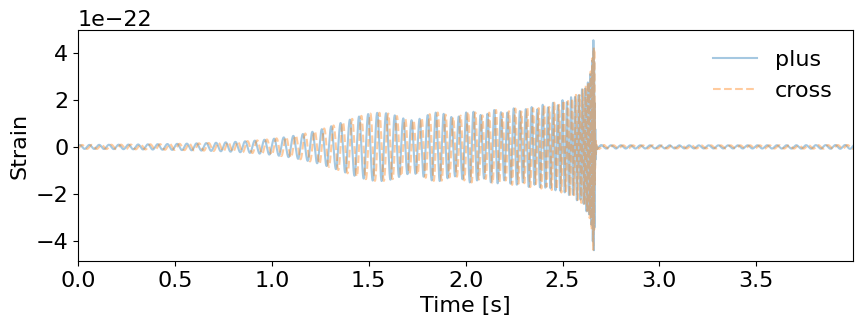

In [23]:
waveform_generator = make_waveform_generator(approximant="IMRPhenomPv2")
bilby_logger.setLevel(logging.DEBUG)
fig = plot_waveform(waveform_generator, dict(mass_1=20., mass_2=25., psi=0.5), polarisation='both')

Q: What happens if we increase chirp-mass?

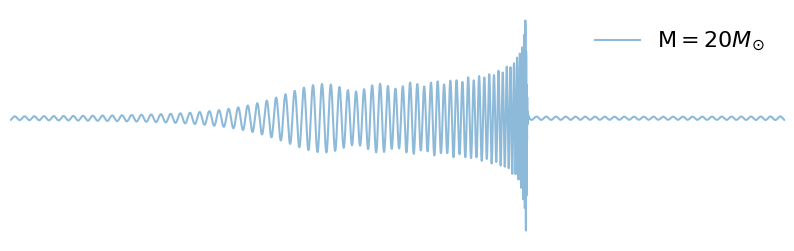

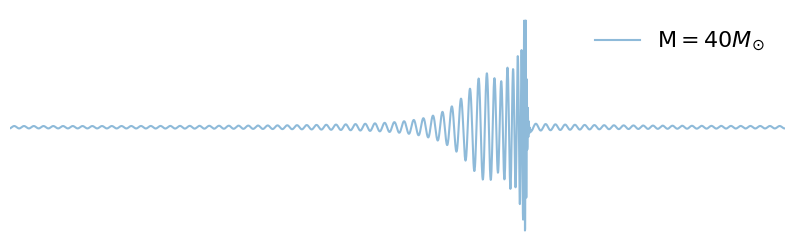

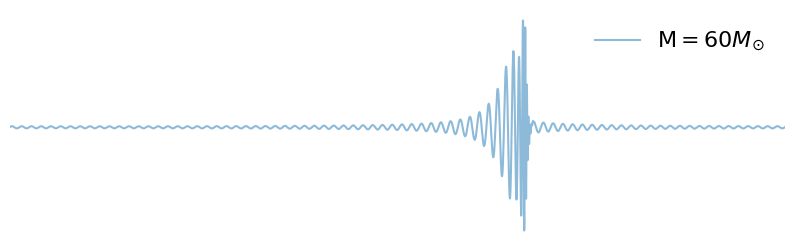

In [24]:
bilby_logger.setLevel(logging.ERROR) # turn off logging
for mc in np.linspace(20, 60, 3):
    m1, m2 = chirp_mass_and_mass_ratio_to_component_masses(mc, 1)
    signal_parameters = dict(mass_1=m1, mass_2=m2)
    fig = plot_waveform(waveform_generator, signal_parameters, label=r"$\mathcal{M} = "+ f"{int(mc)}" + "M_{\odot}$")
    fig.axes[0].axis('off') 
    fig.axes[0].legend(frameon=False)

Playing around with some interactive plots can also help build some intuition:

In [25]:
from ipywidgets import interact

# @interact(a_1=(0.01, 1.0, 0.1)) # uncomment to enable interactive plot
def interact_a1(a_1=0.5):
    fig = plot_waveform(waveform_generator, dict(a_1=0.01, a_2=1), label=f"a_1=0.01", color="tab:red")
    fig = plot_waveform(waveform_generator, dict(a_1=a_1, a_2=1), fig=fig, label=f"a_1={a_1:.2f}", color="tab:blue")
    fig.axes[0].axis('off') 
    fig.axes[0].legend(frameon=False)
    fig.axes[0].set_xlim(1.2, 2.8)
    

In [26]:

#@interact(dist=(1000, 10000, 500)) # uncomment to enable interactive plot
def interact_dist(dist=2000):
    fig = plot_waveform(waveform_generator, dict(luminosity_distance=1000), label=f"d=1000 Mpc", color="tab:red")
    fig = plot_waveform(waveform_generator, dict(luminosity_distance=dist), fig=fig, label=f"d={dist} Mpc", color="tab:blue")
    fig.axes[0].legend(frameon=False)
    fig.axes[0].set_ylim(-7e-22,7e-22)
    



# CBC Parameter Estimation

Finally, we get to actual parameter estimation for gravitational waves! 

## Simulate a signal 

We start by first simulating a signal (using the same code as the previous section for waveform generation)

In [27]:
import bilby
import numpy as np
import logging

bilby_logger = logging.getLogger("bilby")
bilby_logger.setLevel(logging.INFO)

# Simulate signal
duration, sampling_freq, min_freq = 4, 1024., 20
injection_parameters = dict(
    mass_1=36.0, mass_2=29.0,  # 2 mass parameters
    a_1=0.1, a_2=0.1, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0,  # 6 spin parameters
    ra=1.375, dec=-1.2108, luminosity_distance=2000.0, theta_jn=0.0,  # 7 extrinsic parameters
    psi=2.659, phase=1.3,
    geocent_time=1126259642.413,
)
inj_m1, inj_m2 = injection_parameters['mass_1'], injection_parameters['mass_2']
inj_chirp_mass = bilby.gw.conversion.component_masses_to_chirp_mass(inj_m1, inj_m2)
inj_q = bilby.gw.conversion.component_masses_to_mass_ratio(inj_m1, inj_m2)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_freq,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(
        waveform_approximant="IMRPhenomD",
        reference_frequency=20.0,
        minimum_frequency=min_freq,
    )
)


This is the signal we will inject into the detector noise


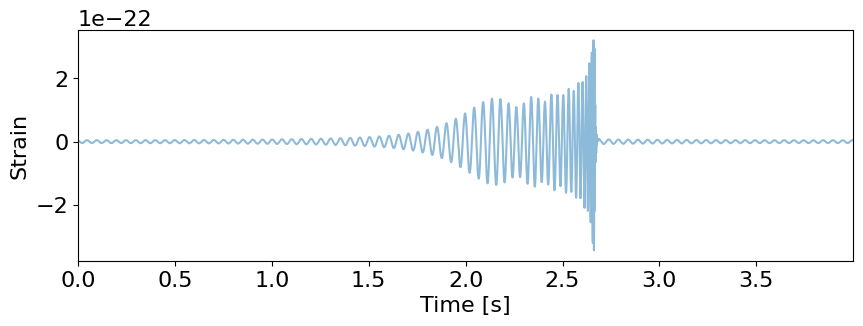

In [28]:
print("This is the signal we will inject into the detector noise")
fig = plot_waveform(waveform_generator, injection_parameters)

## Inject the signal into an interferometer's data stream

We can now simulate some detector noise and inject this signal into the detector-noise

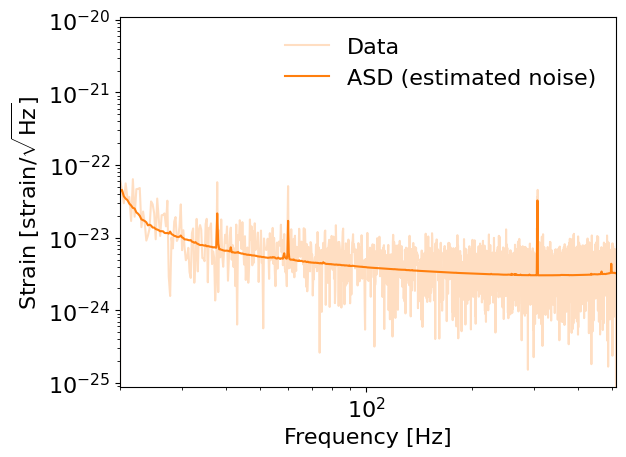

In [29]:
# Inject the signal into 1 detectors LIGO-Hanford (H1) at design sensitivity
ifos = bilby.gw.detector.InterferometerList(["H1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_freq,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 2,
)
ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters
)

for interferometer in ifos:
    analysis_data = abs(interferometer.frequency_domain_strain)
    fig = plt.figure()
    plt.loglog(interferometer.frequency_array, analysis_data, label="Data", color="tab:orange", alpha=0.25)
    plt.loglog(interferometer.frequency_array, abs(interferometer.amplitude_spectral_density_array),
               label="ASD (estimated noise)", color="tab:orange")
    plt.xlim(interferometer.minimum_frequency, interferometer.maximum_frequency)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel(r'Strain [strain/$\sqrt{\rm Hz}$]')
    plt.legend(frameon=False)

### Notes about noise:

- Lots of short duration glitches
- The main contribution to LIGO/Virgo/KAGRA data is coloured Gaussian noise.
- Constant frequency "lines"


The Gaussian noise is described by the noise amplitude (power) spectral density, ASD (PSD).

Most conveniently described in the frequency domain using a [circularly-symmetric complex normal distribution](https://en.wikipedia.org/wiki/Complex_normal_distribution#Circularly-symmetric_normal_distribution).


#### Power/Ampitude-spectral-density generation (PSD/ASD)
- Average over data (normally do this)
  - Divide a long chunk of data and average the power in each chunk
  - Assumes the PSD does not vary with time
  - Assumes data are Gaussian over the full time stretch
  - Has well defined statistical uncertainty
- Fit a parameterised model to the data (eg using instrumental info from Dan Brown's talk)
  - E.g., `BayesLine`
  - Describing the PSD requires lots of parameters
  - Estimating all these parameters is difficult and computationally expensive
  - Especially expensive marginalise over the uncertainty in the model while fitting CBC signal models
  
#### Glitches
- Short term, terrestrial, non-Gaussian transients
- Can bias parameter estimation if overlapping signal
- Can bias PSD estimation
To mitigate:

- Zero out data containing glitch, "gating"
  - Also potentially removes signal
  - Can bias PSD estimation if care is not taken
- Fit a parameterised model to remove the glitch
  - E.g., `BayesWave`
  - Describing the PSD requires lots of parameters
  - Estimating all these parameters is difficult and computationally expensive
  - Especially expensive marginalise over the uncertainty in the model while fitting CBC signal models

#### Lines

- Data at specific frequencies are persistently non-Gaussian and non-stationary
- Large amplitude can cause spectral leakage
  - Need to apply a window
- Many have known causes
  - Suspension "violin" modes
  - Calibration lines
  - Mains power lines
  - ...
- Some can be subtracted ("cleaned") from the data stream
- Can be correlated between detectors
- Commonly not analysed when searching for long-duration signals
- Included in compact binary coalescence parameter estimation (for now...)

## Create priors for analysis

Since sampling all parameters will take a long time, we set delta-functions to all but one mass parameter (chirp-mass). 

In [30]:
# We sample in chirp-mass and mass-ratio, however--these are quite un-astrophysical priors
# but in post-processing convert to uniform-in-component masses 
priors = bilby.gw.prior.BBHPriorDict()
for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
    "theta_jn",
    "luminosity_distance",
]:
    priors[key] = injection_parameters[key]
priors["mass_ratio"] = inj_q
priors["chirp_mass"] = bilby.gw.prior.UniformInComponentsChirpMass(
    minimum=inj_chirp_mass - 5,
    maximum=inj_chirp_mass + 5
)

# Perform a check that the prior does not extend to a parameter space longer than the data
priors.validate_prior(duration, min_freq);

True

Making some plots of the priors:

Text(0.5, 0, 'Chirp Mass $M_{\\odot}$')

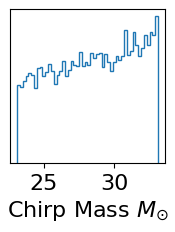

In [31]:
mc = priors.sample(10000)['chirp_mass']
fig, ax = plt.subplots(figsize=(2,2))
ax.hist(mc, histtype='step', bins=50)
ax.set_yticks([])
ax.set_xlabel("Chirp Mass " + r"$M_{\odot}$" );

## Create the likelihood to use for analysis

Similar to the line-signal in Gaussian noise case, we assume that the GW signal is embedded in some Gaussian noise. We also assume that the noise is stationary.

With these asumptions, we can use the [Whittle likelihood](https://en.wikipedia.org/wiki/Whittle_likelihood): 

\begin{align}
\mathcal{L}(d | \theta) = \prod^{\rm{H, L, V}}_{i}\ \prod^{20-2048Hz}_{j} \frac{1}{2 \pi\  \rm{PSD}_{i,j} } \exp\left( -\frac{|\tilde{d}_{i,j} - \tilde{h}_{i,j}(\theta)|^2}{2\ \rm{PSD}_{i,j} } \right).
\end{align}

Here:
- `d` is the frequency-domain strain data, 
- `h` is the template waveform

This can be instantiated in bilby like so:


In [32]:
# the IFOs contain the data and PSD for each detector
# the waveform generator can generate differnt h(t)
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, 
    waveform_generator=waveform_generator,
)

## Run inference

In [33]:
if RE_RUN_SLOW_CELLS:
    # Run sampler.  In this case we're going to use the `dynesty` sampler
    result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        npoints=250,
        nlive=100, walks=25,
        dlogz=0.1,
        injection_parameters=injection_parameters,
        outdir=OUTDIR,
        label="injection",
        conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
        result_class=bilby.gw.result.CBCResult,
    )
else:
    print("Skipping sampling...")
    fn = f"{OUTDIR}/injection_result.json"
    download(INJECTION_URL, fn)
    result = bilby.gw.result.CBCResult.from_json(filename=fn)
    print("Loaded result!")

Skipping sampling...
Loaded result!


## Make some plots

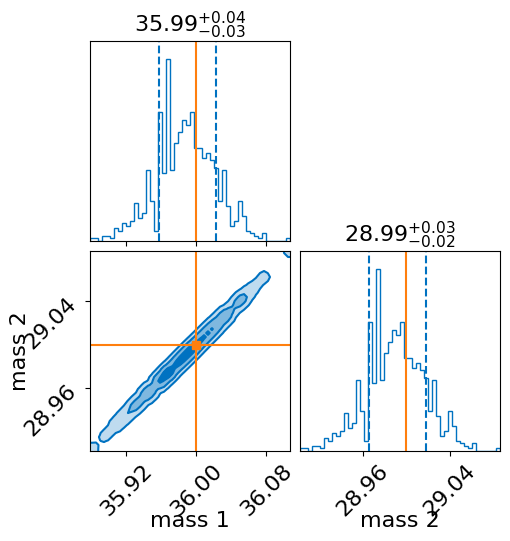

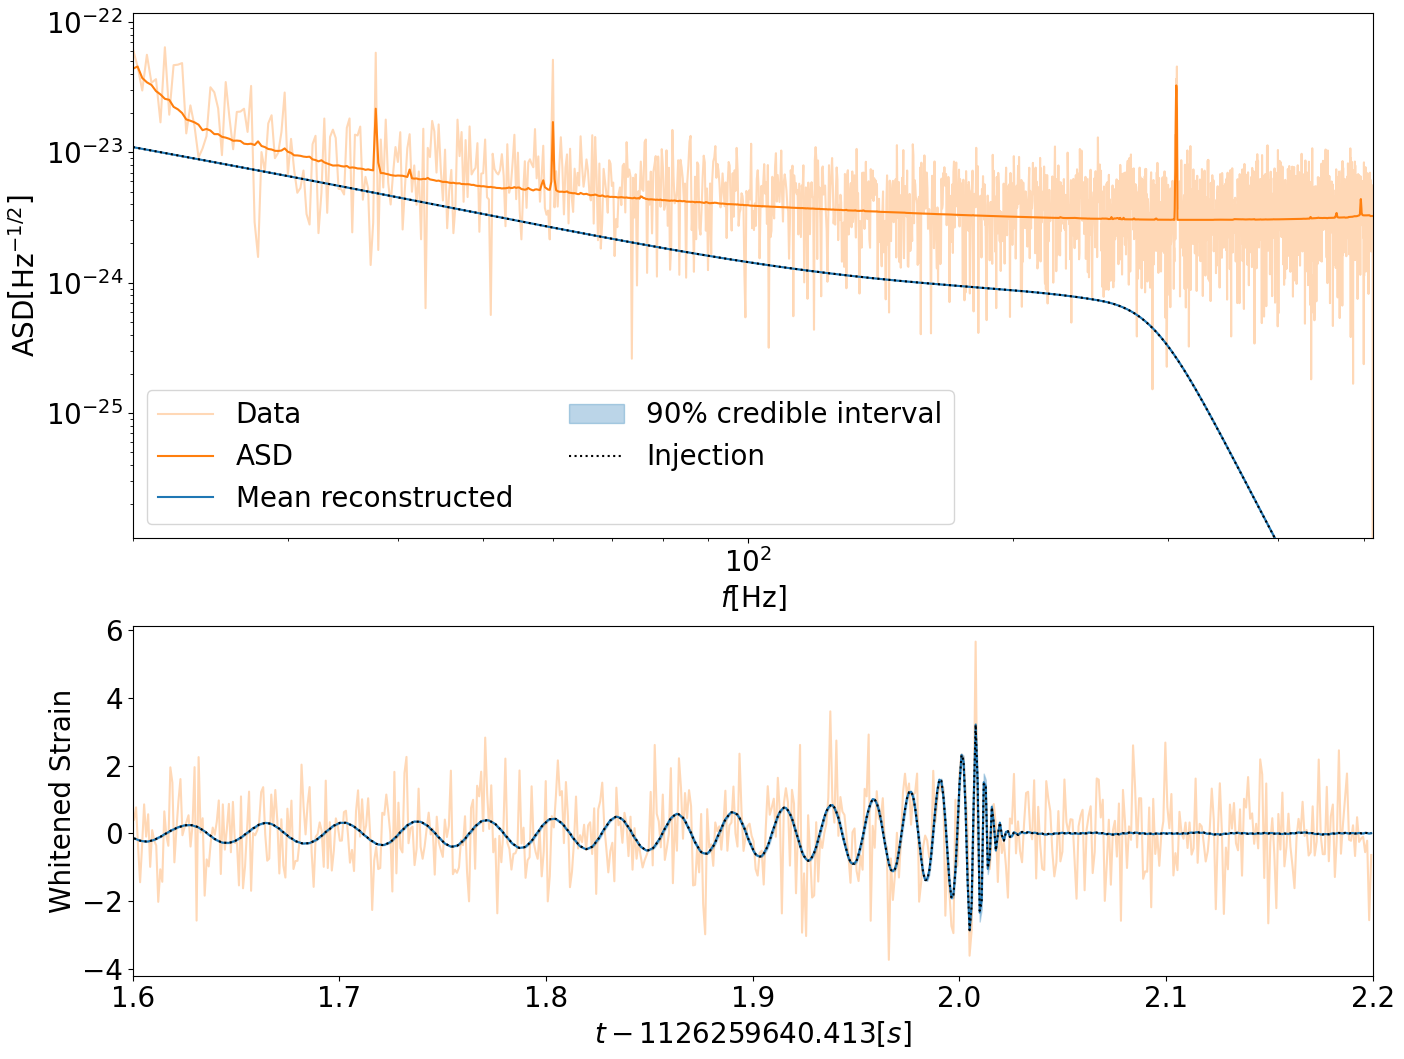

In [34]:
result.plot_corner(parameters=["mass_1", "mass_2"], truths=[inj_m1, inj_m2], save=False)
for interferometer in ifos:
    fig = result.plot_interferometer_waveform_posterior(
        interferometer=interferometer, save=False
    )
    plt.show()

## Cleanup

In [35]:
# lets clear up some memory before proceeding to the next section!
del result
del ifos

# Analysis of GW150914

Lets analyse a real event! 

## Setup
First we import some functions so we dont need to put in the full path 

In [36]:
import numpy as np
import bilby
from bilby import run_sampler
from bilby.core.prior import Constraint, Uniform
from bilby.gw.conversion import (
    convert_to_lal_binary_black_hole_parameters,
    generate_all_bbh_parameters
)
from bilby.gw.detector.networks import InterferometerList
from bilby.gw.detector.psd import PowerSpectralDensity
from bilby.gw.likelihood import GravitationalWaveTransient
from bilby.gw.prior import BBHPriorDict
from bilby.gw.result import CBCResult
from bilby.gw.source import lal_binary_black_hole
from bilby.gw.utils import get_event_time
from bilby.gw.waveform_generator import WaveformGenerator
from gwpy.plot import Plot as GWpyPlot
from gwpy.timeseries import TimeSeries
import os
import logging 
bilby_logger = logging.getLogger("bilby")
bilby_logger.setLevel(logging.ERROR)

## Downloading IFO data

Now we download the raw data and make some plots

In [37]:
def download_strain(ifo_name, start_time, end_time, outdir):
    """Download strain data from GWOSC"""
    fname = f"{outdir}/{ifo_name}-{start_time}-{end_time}.hdf5"
    if os.path.exists(fname):
        data = TimeSeries.read(fname)
    else:
        data = TimeSeries.fetch_open_data(ifo_name, start_time, end_time)
        data.write(fname)
    return data

interferometers = InterferometerList(["H1", "L1"])
trigger_time = get_event_time("GW150914")

start_time = trigger_time - 3
duration = 4
end_time = start_time + duration
roll_off = 0.2

# Get raw data
raw_data = {}
for ifo in interferometers:
    print(
        f"Getting {ifo.name} analysis data segment (can take ~ 30s)"
    )
    analysis_data = download_strain(ifo.name, start_time, end_time, outdir=OUTDIR)
    ifo.strain_data.roll_off = roll_off
    ifo.strain_data.set_from_gwpy_timeseries(analysis_data)
    raw_data[ifo.name] = analysis_data

Getting H1 analysis data segment (can take ~ 30s)
Getting L1 analysis data segment (can take ~ 30s)


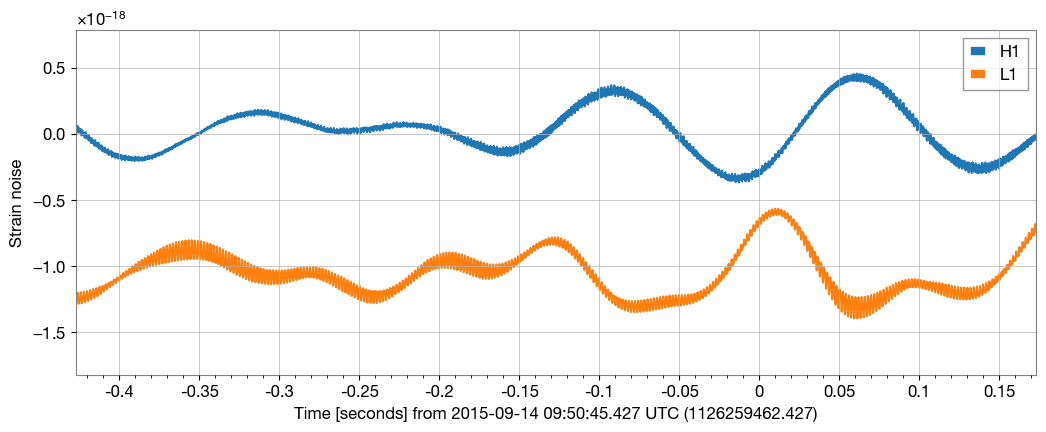

In [38]:
# plot raw data:
plot = GWpyPlot(figsize=(12, 4.8))
ax = plot.add_subplot(xscale='auto-gps')
for ifo_name, data in raw_data.items():
    ax.plot(data, label=ifo_name)
ax.set_epoch(1126259462.427)
ax.set_xlim(1126259462, 1126259462.6)
ax.set_ylabel('Strain noise')
ax.legend()
plot.show()

Woah. That looks terrible. Where is the nobel-prize winning poster-child signal? 

We may need to clean up the data a bit to actually 'see' the signal. Lets get the data for the PSD and take a look at the noise once again

In [39]:
# downloading data
psd_start_time = start_time + duration
psd_duration = 128
psd_end_time = psd_start_time + psd_duration
psd_tukey_alpha = 2 * roll_off / duration
overlap = duration / 2

for ifo in interferometers:
    print(
        f"Getting {ifo.name} PSD data segment (can take ~ 1min)"
    )
    psd_data = download_strain(
        ifo.name, psd_start_time, psd_end_time, outdir=OUTDIR
    )
    psd = psd_data.psd(
        fftlength=duration, overlap=overlap, window=("tukey", psd_tukey_alpha),
        method="median"
    )
    ifo.power_spectral_density = PowerSpectralDensity(
        frequency_array=psd.frequencies.value, psd_array=psd.value
    )

Getting H1 PSD data segment (can take ~ 1min)
Getting L1 PSD data segment (can take ~ 1min)


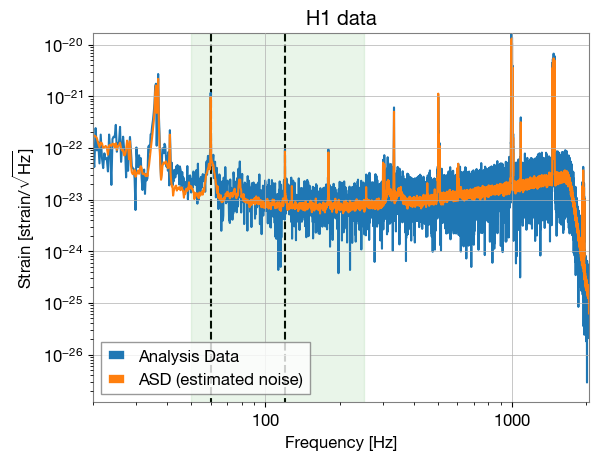

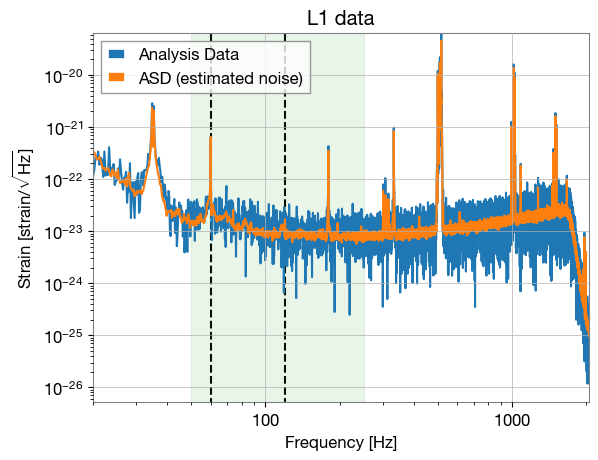

In [40]:
# plotting
for ifo in interferometers:
    analysis_data = abs(ifo.frequency_domain_strain)
    plt.loglog(ifo.frequency_array, analysis_data, label="Analysis Data")
    plt.loglog(ifo.frequency_array, abs(ifo.amplitude_spectral_density_array),
               label="ASD (estimated noise)")
    plt.xlim(ifo.minimum_frequency, ifo.maximum_frequency)
    ymin_max = [min(analysis_data), max(analysis_data)]
    plt.vlines([60, 120], *ymin_max, ls="--", color='k', zorder=-10)
    plt.fill_betweenx(ymin_max, 50, 250, color='tab:green', alpha=0.1)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel(r'Strain [strain/$\sqrt{\rm Hz}$]')
    plt.title(f"{ifo.name} data")
    plt.ylim(*ymin_max)
    plt.legend()
    plt.show()

Lets `notch` out the 60 and 120 Hz `violin` modes (black vertical lines), and only keep data within the 50-250Hz range (marked in green) from the raw data and re-plot:

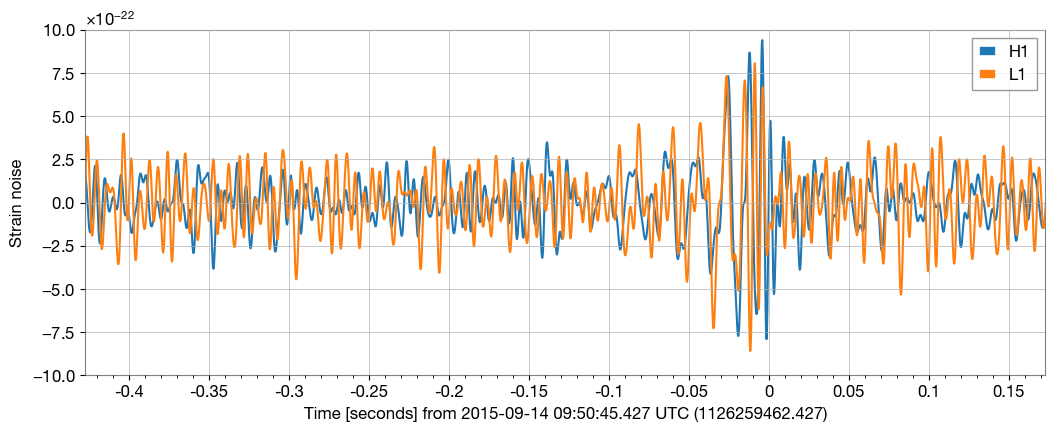

In [41]:
plot = GWpyPlot(figsize=(12, 4.8))
ax = plot.add_subplot(xscale='auto-gps')
for ifo_name, data in raw_data.items():
    filtered_data = data.bandpass(50, 250).notch(60).notch(120)
    ax.plot(filtered_data, label=ifo_name)
ax.set_epoch(1126259462.427)
ax.set_xlim(1126259462, 1126259462.6)
ax.set_ylim(-1e-21, 1e-21)
ax.set_ylabel('Strain noise')
ax.legend()
plot.show()

Noiceee... Lets plot the signals in the frequency domain:

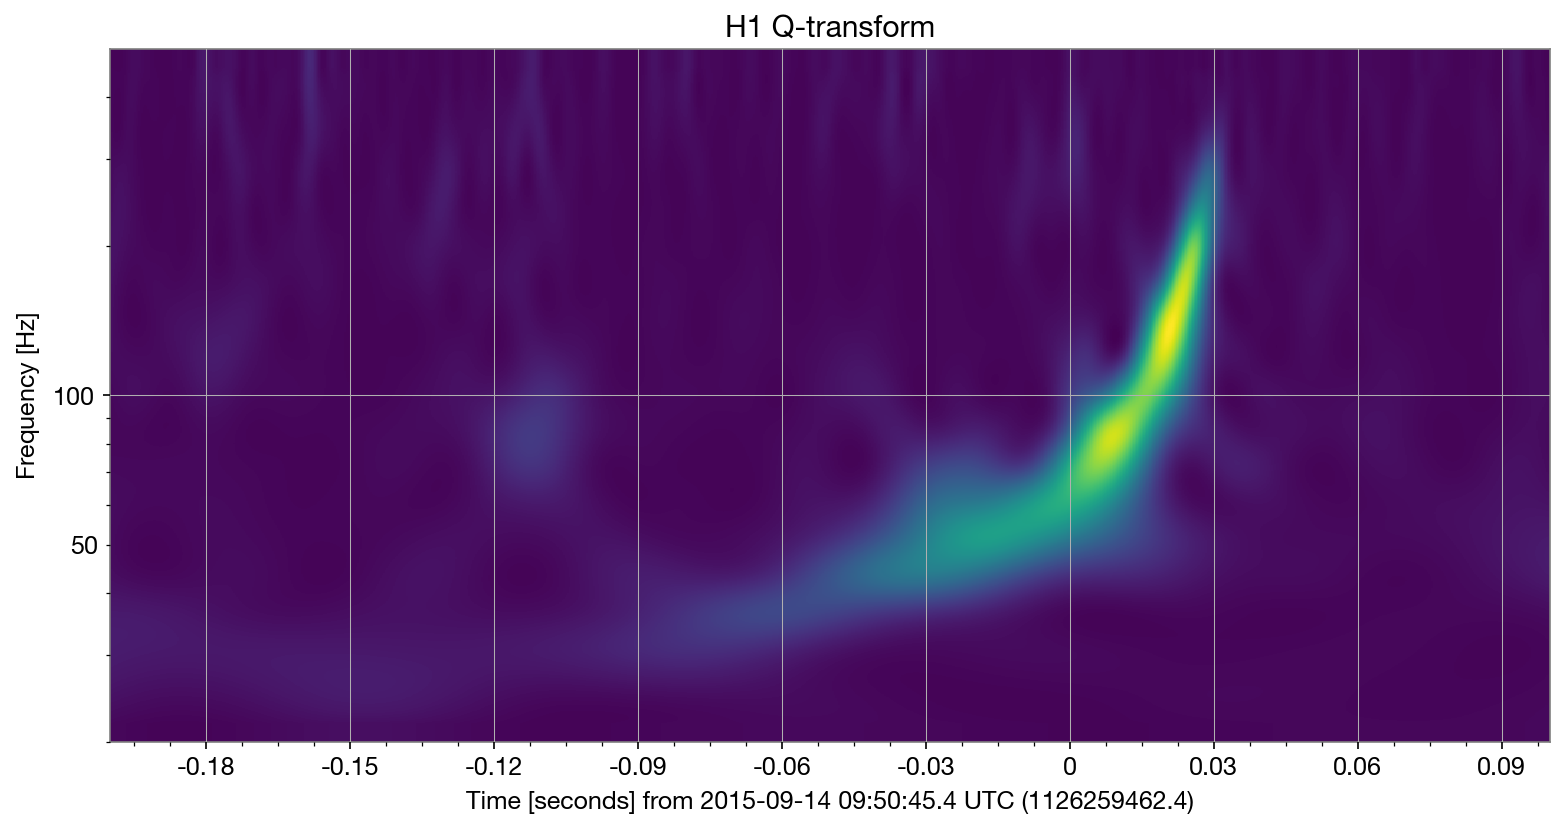

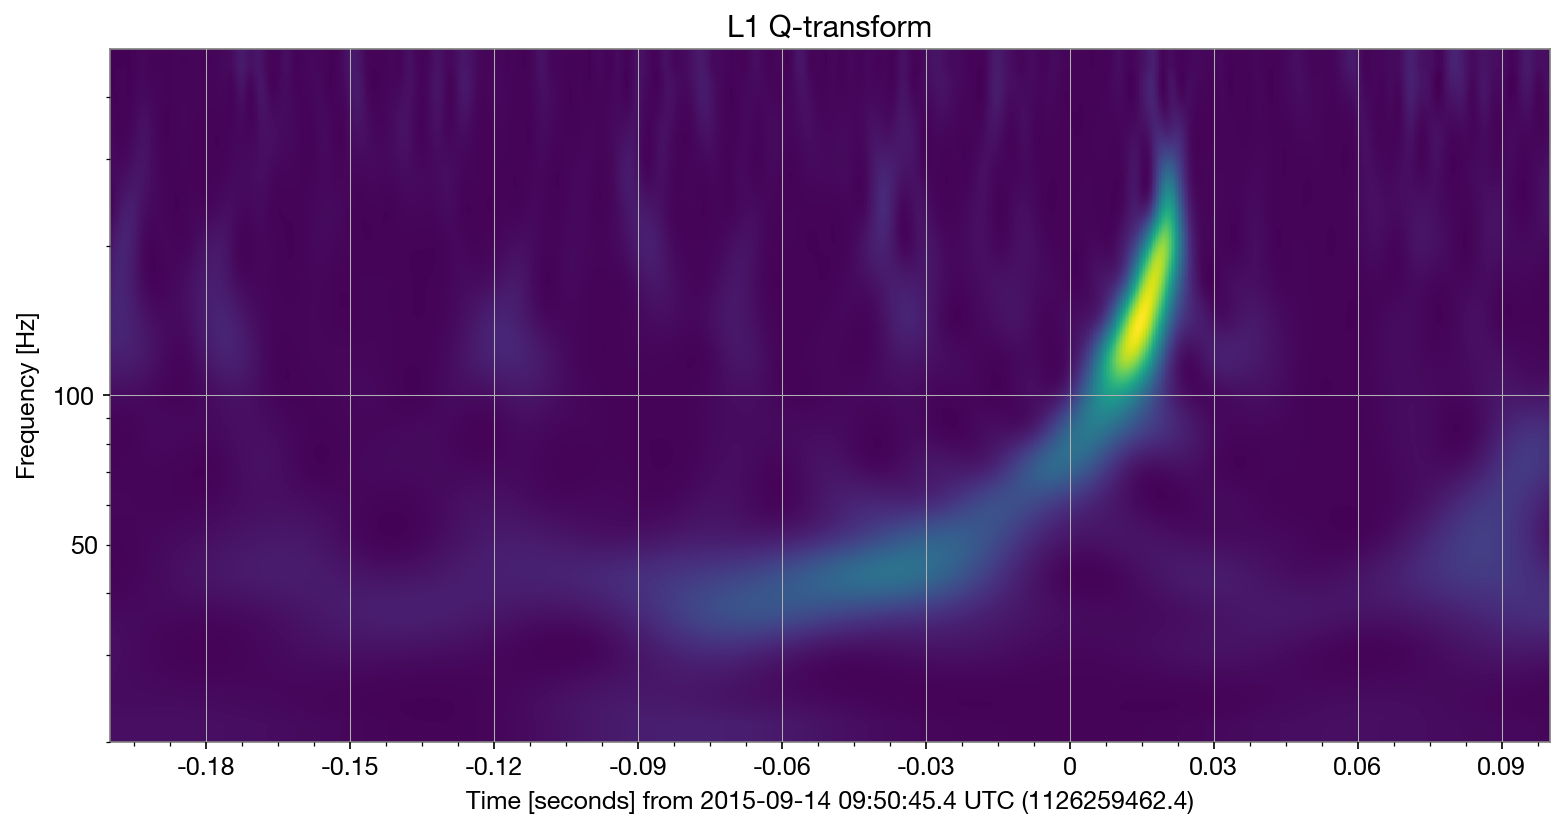

In [42]:
tc = trigger_time

for ifo_name, data in raw_data.items():
    qtrans = data.q_transform(
        frange=(20,500), fres = 0.05,
        outseg=(tc-0.2, tc+0.1)
    )
    plot = qtrans.plot(cmap = 'viridis', dpi = 150)
    ax = plot.gca()
    ax.set_title(f'{ifo_name} Q-transform')
    ax.set_epoch(trigger_time)
    ax.set_yscale('log')


## Getting priors

Now lets write down our priors for this event's analysis. Note that again we set several delta functions and restrict the search space to speed up analysis for the sake of this tutorial. 

In [43]:
# setup the prior
from bilby.core.prior import Uniform, PowerLaw, Sine, Constraint, Cosine
from corner import corner
import pandas as pd

# typically we would use a priors with wide bounds:
tc = trigger_time
priors = BBHPriorDict(dict(
    mass_ratio=Uniform(name='mass_ratio', minimum=0.125, maximum=1),
    chirp_mass=Uniform(name='chirp_mass', minimum=25, maximum=31),
    mass_1=Constraint(name='mass_1', minimum=10, maximum=80),
    mass_2=Constraint(name='mass_2', minimum=10, maximum=80),
    a_1=Uniform(name='a_1', minimum=0, maximum=0.99),
    a_2=Uniform(name='a_2', minimum=0, maximum=0.99),
    tilt_1=Sine(name='tilt_1'),
    tilt_2=Sine(name='tilt_2'),
    phi_12=Uniform(name='phi_12', minimum=0, maximum=2 * np.pi, boundary='periodic'),
    phi_jl=Uniform(name='phi_jl', minimum=0, maximum=2 * np.pi, boundary='periodic'),
    luminosity_distance=PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000),
    dec=Cosine(name='dec'),
    ra=Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic'),
    theta_jn=Sine(name='theta_jn'),
    psi=Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic'),
    phase=Uniform(name='phase', minimum=0, maximum=2 * np.pi, boundary='periodic'),
    geocent_time=Uniform(minimum=tc - 0.1, maximum=tc + 0.1, latex_label="$t_c$", unit="$s$")
))

# HACK: for this example (to make analysis faster) we will use a prior with tighter bounds
priors['luminosity_distance'] = 419.18
priors['mass_1'] = Constraint(name='mass_1', minimum=30, maximum=50)
priors['mass_2'] = Constraint(name='mass_2', minimum=20, maximum=40)
priors['ra'] = 2.269
priors['dec'] = -1.223
priors['geocent_time'] = tc
priors['theta_jn'] = 2.921
priors['phi_jl'] = 0.968
priors['psi'] = 2.659
# dont do this in a real run 

prior_samples = priors.sample(10000)
prior_samples_df = pd.DataFrame(prior_samples)


Plots of some priors:


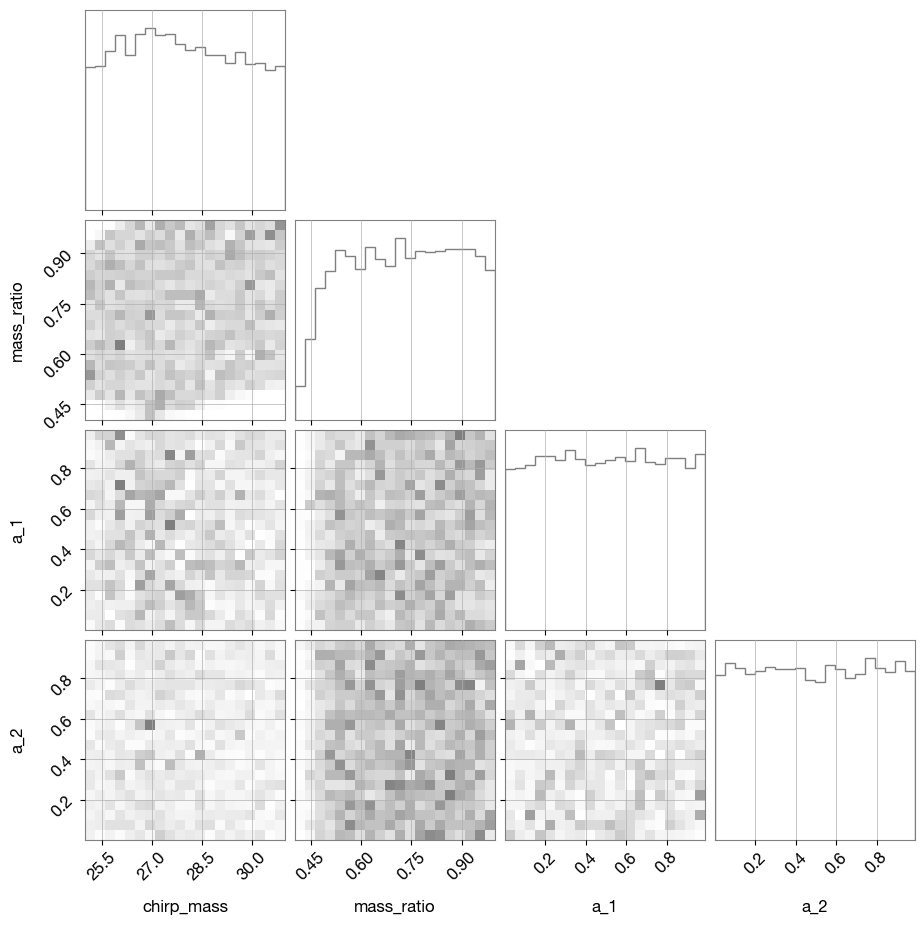

In [44]:
parameters = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2']
fig = corner(
    prior_samples_df[parameters], plot_datapoints=False, 
    plot_contours=False, plot_density=True,
    color="tab:gray",
    labels=parameters,
)

Lets convert some parameters and see what the prior-distributions we get

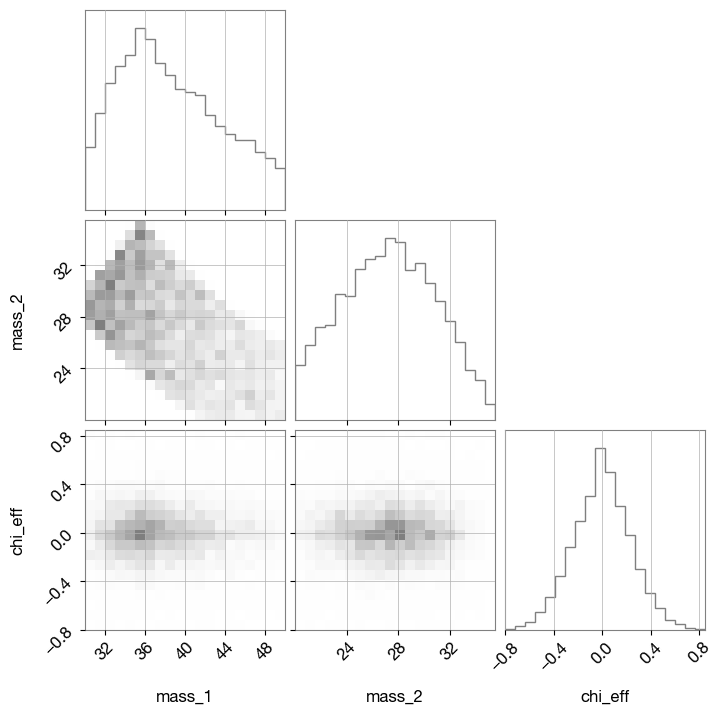

In [45]:
from bilby.gw.conversion import generate_mass_parameters

prior_samples = generate_mass_parameters(prior_samples)
prior_samples['cos_tilt_1'] = np.cos(prior_samples['tilt_1'])
prior_samples['cos_tilt_2'] = np.cos(prior_samples['tilt_2'])
s1z = prior_samples["a_1"] * prior_samples['cos_tilt_1']
s2z = prior_samples["a_2"] * prior_samples['cos_tilt_2']
q = prior_samples['mass_ratio']
prior_samples['chi_eff'] = (s1z + s2z * q) / (1 + q)
prior_samples_df = pd.DataFrame(prior_samples)
prior_samples_df

parameters = ['mass_1', 'mass_2', 'chi_eff']
fig = corner(
    prior_samples_df[parameters],
    plot_datapoints=False, plot_contours=False, plot_density=True,
    color="tab:gray", labels=parameters,
)


## Inference step

In [46]:
waveform_generator = WaveformGenerator(
    duration=interferometers.duration,
    sampling_frequency=interferometers.sampling_frequency,
    frequency_domain_source_model=lal_binary_black_hole,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(
        waveform_approximant="IMRPhenomPv2",
        reference_frequency=20)
)

likelihood = GravitationalWaveTransient(
    interferometers=interferometers, waveform_generator=waveform_generator,
    priors=priors, time_marginalization=False, distance_marginalization=False,
    phase_marginalization=True, jitter_time=False
)


if RE_RUN_SLOW_CELLS:
    bilby_logger.setLevel(logging.INFO)
    result = run_sampler(
        likelihood=likelihood, priors=priors, save=True,
        label="GW150914",
        nlive=50, walks=25, # HACK: use defaults nlive/walks (much more aggressive)
        conversion_function=generate_all_bbh_parameters,
        result_class=CBCResult,
    )
else:
    print("Skipping sampling...")
    fn = f"{OUTDIR}/GW150914_result.json"
    download(GW150914_URL, fn)
    result = bilby.gw.result.CBCResult.from_json(filename=fn)
    print("Loaded result!")


Skipping sampling...
Loaded result!


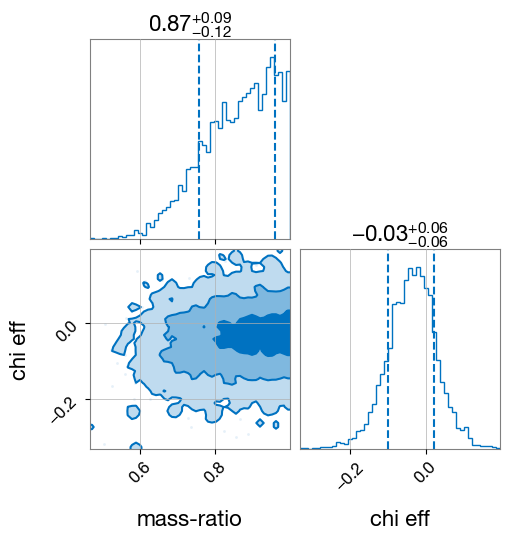

In [47]:
fig = result.plot_corner(parameters=["mass_ratio", "chi_eff"], save=False)

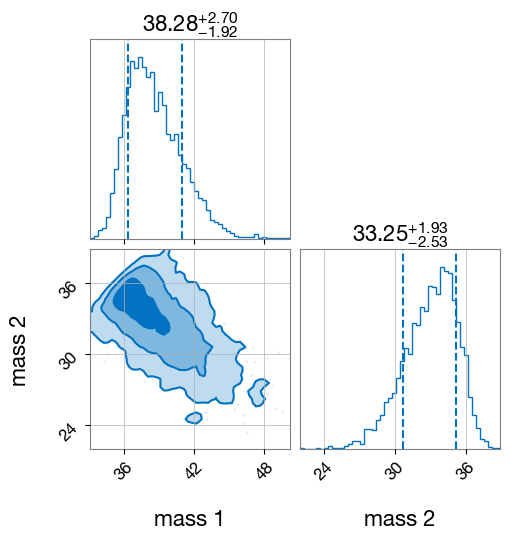

In [48]:
fig = result.plot_corner(parameters=["mass_1", "mass_2"], save=False)

NOTE: To get some proper results, we'd have to run with more robust sampler settings and wider priors. 

# Accessing GWTC parameter estimation results 

The GWTC data and parameter estimation results are all online (eg https://zenodo.org/record/5546663).
Lets download one result and make some plots:

In [49]:
import logging
OUTDIR="outdir/"
GW200308_fn = f"{OUTDIR}/GW200308_result.h5"
download(GW200308_URL, GW200308_fn)

In [50]:
import h5py
GW200308_result = h5py.File(GW200308_fn, "r")
print("GW200308 samples loaded!")

GW200308 samples loaded!


Lets look at what is stored:

In [51]:
print(list(GW200308_result.keys()))
print(list(GW200308_result['C01:IMRPhenomXPHM'].keys()))

['C01:IMRPhenomXPHM', 'C01:Mixed', 'C01:SEOBNRv4PHM', 'history', 'version']
['approximant', 'calibration_envelope', 'config_file', 'description', 'injection_data', 'meta_data', 'posterior_samples', 'priors', 'psds', 'skymap', 'version']


In [52]:
print("Parameters stored:")
for i in GW200308_result['C01:IMRPhenomXPHM']['posterior_samples'].dtype.names:
    print(f"  {i}")

Parameters stored:
  luminosity_distance
  geocent_time
  recalib_H1_frequency_0
  recalib_H1_frequency_1
  recalib_H1_frequency_2
  recalib_H1_frequency_3
  recalib_H1_frequency_4
  recalib_H1_frequency_5
  recalib_H1_frequency_6
  recalib_H1_frequency_7
  recalib_H1_frequency_8
  recalib_H1_frequency_9
  recalib_L1_frequency_0
  recalib_L1_frequency_1
  recalib_L1_frequency_2
  recalib_L1_frequency_3
  recalib_L1_frequency_4
  recalib_L1_frequency_5
  recalib_L1_frequency_6
  recalib_L1_frequency_7
  recalib_L1_frequency_8
  recalib_L1_frequency_9
  recalib_V1_frequency_0
  recalib_V1_frequency_1
  recalib_V1_frequency_2
  recalib_V1_frequency_3
  recalib_V1_frequency_4
  recalib_V1_frequency_5
  recalib_V1_frequency_6
  recalib_V1_frequency_7
  recalib_V1_frequency_8
  recalib_V1_frequency_9
  chirp_mass
  mass_ratio
  a_1
  a_2
  tilt_1
  tilt_2
  phi_12
  phi_jl
  theta_jn
  psi
  phase
  azimuth
  zenith
  recalib_H1_amplitude_0
  recalib_H1_amplitude_1
  recalib_H1_amplitude_2
 

Text(0.5, 0, 'Chirp-mass Msun')

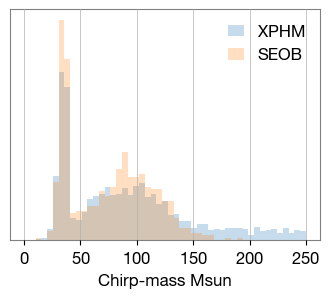

In [53]:
xphm_mc = GW200308_result['C01:IMRPhenomXPHM']['posterior_samples']['chirp_mass'][:]
seob_mc = GW200308_result['C01:SEOBNRv4PHM']['posterior_samples']['chirp_mass'][:]
fig, ax = plt.subplots(figsize=(4,3))
bins = np.linspace(0, 250, 50)
ax.hist(xphm_mc, bins=bins, density=True, histtype='stepfilled', label='XPHM',  lw=2,alpha=0.25)
ax.hist(seob_mc, bins=bins,  density=True, histtype='stepfilled', label='SEOB', lw=2,alpha=0.25)
ax.set_yticks([])
ax.legend(frameon=False)
ax.set_xlabel("Chirp-mass Msun");